I have used a bit different method in vectorizing the data. Refer to the other notebooks with name same as that in the course for looking into the methods being taught there.

Importing Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Loading the dataset

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

Splitting the dataset into train and test

In [3]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

Creating vectorization layer and setting up the vocabulary

In [12]:
# Create and adapt TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization()
vectorize_layer.adapt(train_reviews)


# Get vocabulary and ensure uniqueness
vocabulary = vectorize_layer.get_vocabulary()
unique_vocabulary = sorted(set(vocabulary))  # Remove duplicates and sort


# Ensure required tokens are at the start
final_vocabulary = ['', '[UNK]'] + [word for word in unique_vocabulary if word not in ['', '[UNK]']]


# Save vocabulary to a text file
vocab_file = "imdb_vocab_subwords.txt"
with open(vocab_file, "w", encoding="utf-8") as f:
    for word in final_vocabulary:
        f.write(word + "\n")

print(f"Vocabulary saved to {vocab_file}")


Vocabulary saved to imdb_vocab_subwords.txt


Loading the vocabulary and creating the vectorization layer

In [13]:
# Load vocabulary from the file
with open("imdb_vocab_subwords.txt", "r", encoding="utf-8") as f:
    loaded_vocabulary = [line.strip() for line in f]
    

# Ensure uniqueness again (just in case)
loaded_vocabulary = sorted(set(loaded_vocabulary))


# Ensure required tokens are at the start
if loaded_vocabulary[:2] != ['', '[UNK]']:
    loaded_vocabulary = ['', '[UNK]'] + [word for word in loaded_vocabulary if word not in ['', '[UNK]']]

    
# Recreate the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(vocabulary=loaded_vocabulary)


print(f"Loaded vocabulary size: {len(loaded_vocabulary)}")


Loaded vocabulary size: 121531


Creating a padding function for padding the text records in dataset

In [16]:
# Data pipeline and padding parameters

SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
MAX_LENGTH = 160
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

def padding_func(sequences):
    # Putting all the elements in a single ragged bacth
    sequences = sequences.padded_batch(batch_size=tf.data.experimental.cardinality(sequences).numpy(),
                                       padded_shapes=[None])
    
    # Output a tensor from a single batch
    sequences = sequences.get_single_element()
    
    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    maxlen=MAX_LENGTH,
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)
    
    # Convert back to tf.data.Dataset
    padded_sequences=tf.data.Dataset.from_tensor_slices(padded_sequences)
    
    return padded_sequences

In [17]:
# Apply the layer to the train and test data
train_sequences_subword = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

Vectorized and padded records are joined with labels and training and testing datasets are created

In [21]:
train_dataset_vectorized = tf.data.Dataset.zip((train_sequences_subword, train_labels))
test_dataset_vectorized = tf.data.Dataset.zip((test_sequences_subword, test_labels))


# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized.cache()
                      .shuffle(SHUFFLE_BUFFER_SIZE)
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE))

test_dataset_final = (test_dataset_vectorized.cache()
                     .prefetch(PREFETCH_BUFFER_SIZE)
                     .batch(BATCH_SIZE))

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [23]:
for seq in train_dataset_final.take(1):  # Inspect one sample
    print(seq)  

(<tf.Tensor: shape=(256, 160), dtype=int32, numpy=
array([[107829,  33978, 116497, ...,  53526,   6135,  38466],
       [ 52743,  93179, 107241, ..., 107975, 107829,  39668],
       [120516,  17403,  27615, ...,  81948,  71958, 107401],
       ...,
       [ 52999, 120516,   7649, ...,  98049, 108194,  11831],
       [101033,  62411,  99798, ...,  52999, 120516,  59567],
       [  5085,  75833,  27255, ...,  99773, 108947,   9284]])>, <tf.Tensor: shape=(256,), dtype=int64, numpy=
array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
     

In [24]:
# Model Parameters
EMBEDDING_DIM = 64
LSTM_DIM = 64
DENSE_DIM = 64

# Ensure tokenizer vocabulary size is correctly retrieved
vocab_size = len(vectorize_layer.get_vocabulary())

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)), 
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 160, 64)             │       7,777,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,852,353 (29.95 MB)

 Trainable params: 7,852,353 (29.95 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
NUM_EPOCHS = 10

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.5921 - loss: 0.6320 - val_accuracy: 0.8414 - val_loss: 0.3682
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.9057 - loss: 0.2466 - val_accuracy: 0.8350 - val_loss: 0.3874
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.9644 - loss: 0.1132 - val_accuracy: 0.8240 - val_loss: 0.5722
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9837 - loss: 0.0527 - val_accuracy: 0.7711 - val_loss: 0.6976
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9836 - loss: 0.0508 - val_accuracy: 0.8180 - val_loss: 0.6754
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9926 - loss: 0.0220 - val_accuracy: 0.8055 - val_loss: 0.9905
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.9952 - loss: 0.0154 - val_accuracy: 0.7799 - val_loss: 1.3425
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.9911 - loss: 0.0253 - val_accu

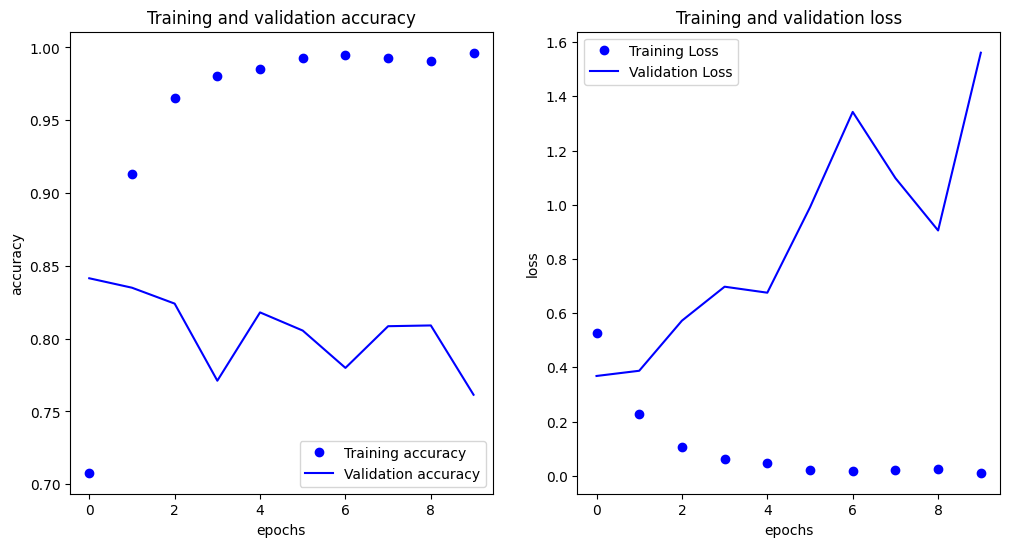

In [27]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

Using different number of neurons for the layers

In [30]:
# Model Parameters
EMBEDDING_DIM = 128
LSTM_DIM = 128
DENSE_DIM = 256

# Ensure tokenizer vocabulary size is correctly retrieved
vocab_size = len(vectorize_layer.get_vocabulary())

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)), # Input is (sequence_length,)
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


NUM_EPOCHS = 10

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6106 - loss: 0.6323 - val_accuracy: 0.8292 - val_loss: 0.3930
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8942 - loss: 0.2685 - val_accuracy: 0.7974 - val_loss: 0.5294
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9549 - loss: 0.1366 - val_accuracy: 0.8185 - val_loss: 0.5874
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9832 - loss: 0.0573 - val_accuracy: 0.8114 - val_loss: 0.5793
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 830ms/step - accuracy: 0.9884 - loss: 0.0380 - val_accuracy: 0.7923 - val_loss: 0.9480
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 613ms/step - accuracy: 0.9941 - loss: 0.0197 - val_accuracy: 0.8102 - val_loss: 1.0043
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 623ms/step - accuracy: 0.9932 - loss: 0.0206 - val_accuracy: 0.7829 - val_loss: 0.8445
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 623ms/step - accuracy: 0.9914 - loss: 0.0277 - val_accuracy: 0.

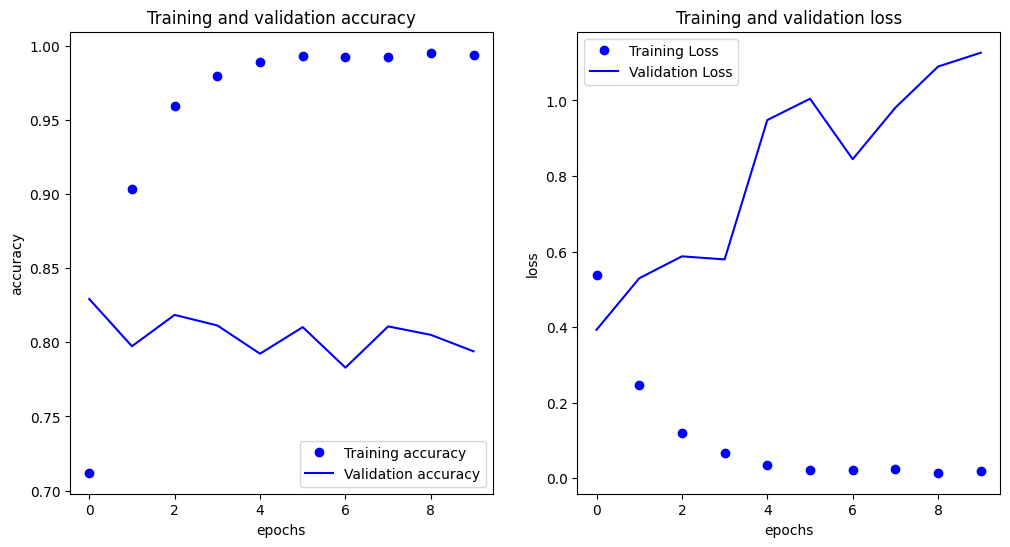

In [31]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when `return_sequences` is True.

In [33]:
import numpy as np

# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 16
LSTM_DIM = 8

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'lstm output units: {LSTM_DIM}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(LSTM_DIM)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [34]:
# Model parameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 16
DENSE_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 64)            │       7,777,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,815,361 (29.81 MB)

 Trainable params: 7,815,361 (29.81 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters, it will take around 2 minutes per epoch in your lab environment. Also, since this is a larger model, it might start to overfit quickly so you may want to use fewer epochs or use a callback to monitor the validation accuracy.

In [36]:
NUM_EPOCHS = 5

# Train the model
history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 268ms/step - accuracy: 0.6102 - loss: 0.6392 - val_accuracy: 0.8327 - val_loss: 0.3935
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.9018 - loss: 0.2582 - val_accuracy: 0.8364 - val_loss: 0.3823
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.9625 - loss: 0.1149 - val_accuracy: 0.8175 - val_loss: 0.4407
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.9819 - loss: 0.0622 - val_accuracy: 0.8213 - val_loss: 0.5873
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 34s 347ms/step - accuracy: 0.9902 - loss: 0.0338 - val_accuracy: 0.7876 - val_loss: 0.8206


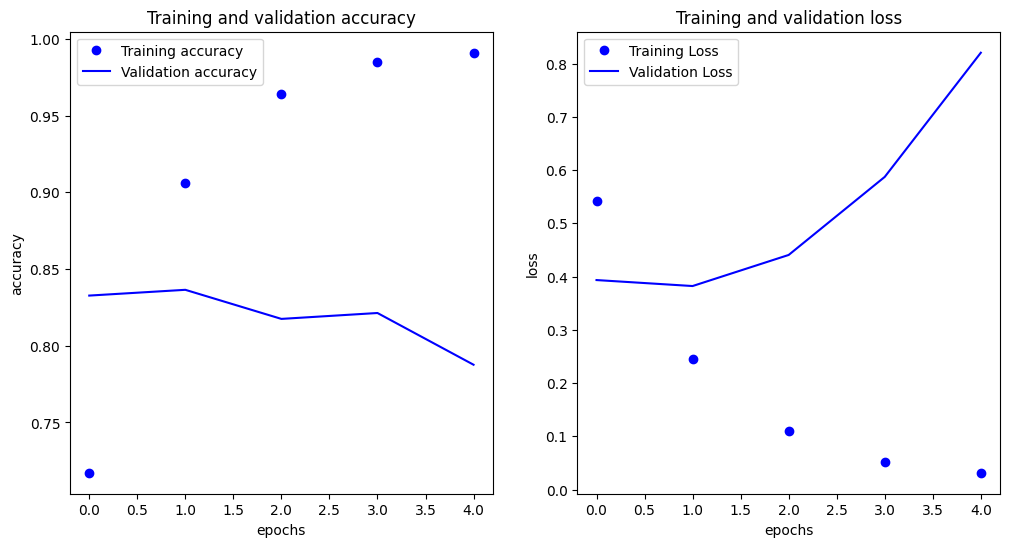

In [38]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)